<a href="https://colab.research.google.com/github/kriselmir/newGitTest_KP/blob/master/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference article & YouTube Video:

https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb


https://www.youtube.com/watch?v=QIUxPv5PJOY&t=125s


# **Stock Price Prediction Using Python & Machine Learning (LSTM)**

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')



In [ ]:
#Get the stock quote
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-16')

#show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.737655
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.879071
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013705
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,12.993064
...,...,...,...,...,...,...
2020-12-10,123.870003,120.150002,120.500000,123.239998,81312200.0,123.239998
2020-12-11,122.760002,120.550003,122.430000,122.410004,86939800.0,122.410004
2020-12-14,123.349998,121.540001,122.599998,121.779999,79184500.0,121.779999


In [ ]:
#Get the number of rows and columns available in the data
df.shape

(2255, 6)

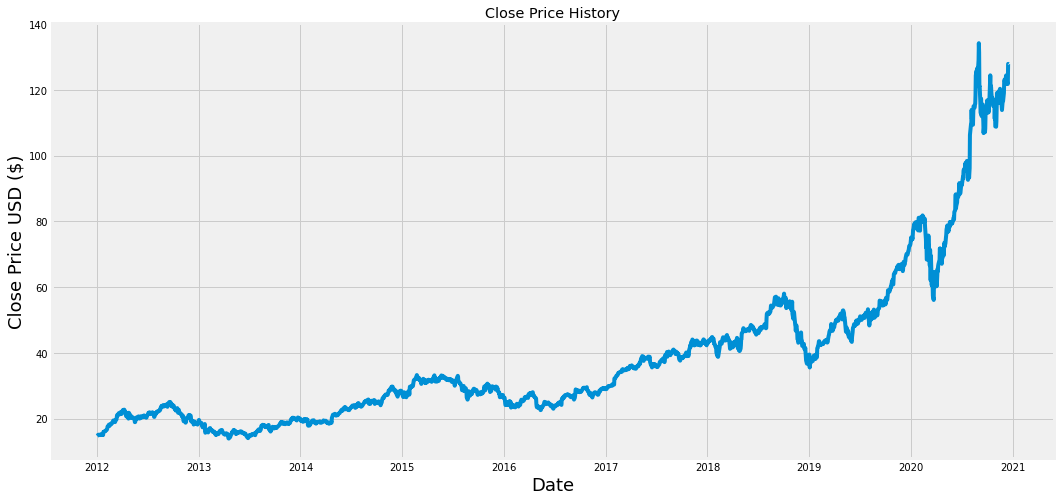

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [ ]:
#Create a new dataframe with only the 'Close Column'
#using .filter preserves the DataFrame, it does not convert to a Series
data = df.filter(['Close'])
#data = df['Close']

#Convert the datafram to a numpy array
dataset = data.values

#set number of training data points
training_data_len = math.ceil(len(dataset) * .8)

training_data_len


1804

In [ ]:
#Scale closing price data (scale 0 - 1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.0061488 ],
       [0.00680527],
       [0.00816869],
       ...,
       [0.89686653],
       [0.94760156],
       [0.94701935]])

In [ ]:
#Create training dataset from scaled_data
train_data = scaled_data[:training_data_len, :]

#split data into x_train (independent variables), and y_train (dependent variable)
x_train = []
y_train = []

# Loop through train_data (closing price) and create x_ & y_train using the 
# 60 previous closing prices as x_train and the 61st closing price as y_train
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  #print x_ and y_train to understand what's happening
  #if i<=63:
  #  print(x_train)
  #  print(y_train)
  #  print()


In [ ]:
#Convert x_train and y_train to NumPy arrays to use for trainig LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape


(1744, 60)

In [ ]:
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
x_train.shape

(1744, 60, 1)

In [ ]:
#build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1744/1744 [==============================] - 34s 19ms/step - loss: 6.6032e-04


In [ ]:
#Create the testing data set
#Create a new array containing scaled values from the rest of the scaled_data 
test_data = scaled_data[training_data_len - 60: , : ]

#Create x_test and y_test data
x_test = []
y_test = dataset[training_data_len:, :] #getting all the rows reserved
            #as test data, but not scaled (0-1). 
            #The unscaled original data (closing stock prices) will be used
            #to compare to the prediceted data to measure 
            #how good the model works.

# loop through test_data (ie. closing price) and create x_train using the 
# 60 previous closing prices 
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60: i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(451, 60, 1)

In [ ]:
#Use test data to predict stock prices
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #undoing scaling of data, restoring actual predicted stock prices in USD


In [ ]:
#Calculate / get value of RMSE
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

4.7250909041257465

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


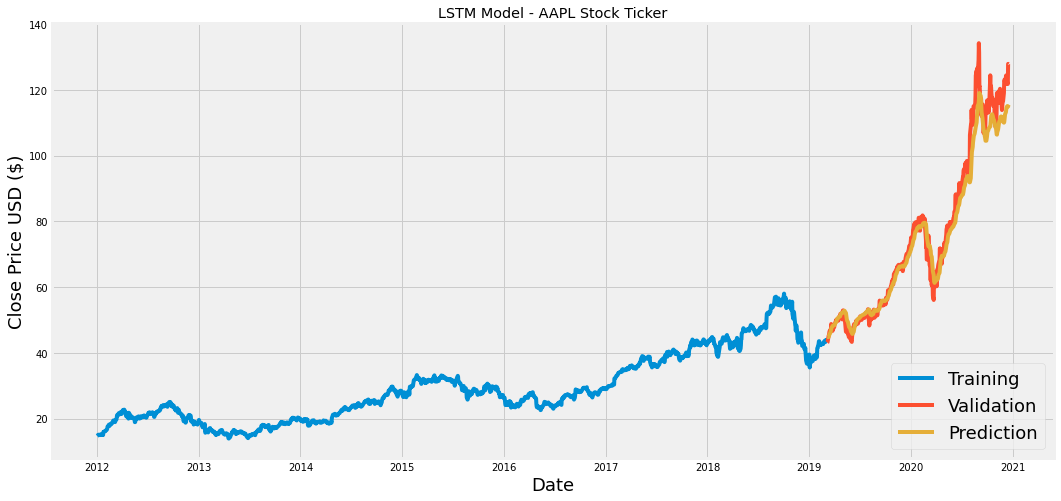

In [ ]:
#Plot data (predicted vs actual)
#create data for the graph
train_data = data.iloc[:training_data_len, :]
valid_data = data.iloc[training_data_len:, :]
valid_data['Predictions'] = predictions

#visualize the model
plt.figure(figsize=(16,8))
plt.title('LSTM Model - AAPL Stock Ticker')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Prediction'], fontsize=18, loc='lower right' )
plt.show()

In [ ]:
#Validation data (actual vs predicted)
valid_data

,Close,Predictions
Date,,
2019-03-07,43.125000,44.869041
2019-03-08,43.227501,44.850960
2019-03-11,44.724998,44.803978
2019-03-12,45.227501,44.895897
2019-03-13,45.427502,45.101891
...,...,...
2020-12-10,123.239998,114.709770
2020-12-11,122.410004,114.921776
2020-12-14,121.779999,114.988449


In [ ]:
#Test model by predicting the last available close price (2020-12-17)
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2020-01-01', end='2020-12-16')

#create a new df
new_df = apple_quote.filter(['Close'])

#get the last 60 days closing price
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

#create new test data
x60_test = []
x60_test.append(last_60_days_scaled)

#transform to numpy array
x60_test = np.array(x60_test)
x60_test = np.reshape(x60_test, (x60_test.shape[0], x60_test.shape[1], 1))

print(x60_test.shape)

#Predict price using model from before
pred_price = model.predict(x60_test)


pred_price = scaler.inverse_transform(pred_price)
print('Predicted price for 2020-12-17', pred_price[0,0])

(1, 60, 1)
Predicted price for 2020-12-17 116.080696


In [ ]:
#get actual closing price
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-12-17', end='2020-12-17')

print(apple_quote2['Close'])

Date
2020-12-17    128.699997
Name: Close, dtype: float64
